# **📌 Model Deep Learning CNN dan MLP (TensorFlow) CIFAR-10 Dataset**

# 1. Bagian MLP (TensorFlow)

# Import library

In [3]:
import tensorflow as tf # Library utama untuk deep learning
import tensorflow_datasets as tfds # Library untuk dataset
import numpy as np # Library untuk manipulasi array
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix # Library untuk metrik evaluasi
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization # Library untuk layer-layer CNN
from tensorflow.keras.models import Sequential # Library untuk model sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Library untuk callbacks
from tensorflow.keras.optimizers import Adam # Library untuk optimizers

# Memuat Dataset CIFAR-10 dan Augmentasi

In [4]:
# Memuat dataset CIFAR-10
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10', # Dataset CIFAR-10
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Fungsi preprocessing
def normalize_img(image, label):
    """Normalisasi gambar: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Mengatur alur data untuk training
BATCH_SIZE = 64
ds_train = ds_train.map(normalize_img)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

# Mengatur alur data untuk testing
ds_test = ds_test.map(normalize_img)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.X6DY9J_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.X6DY9J_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


# Menyusun Model

In [5]:
def create_mlp_model():
    model = Sequential([
        # Flattening input gambar 32x32x3 menjadi 3072 fitur
        Flatten(input_shape=(32, 32, 3)),

        # Layer hidden 1
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Layer hidden 2
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Layer hidden 3
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Layer hidden 4
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        # Layer output
        Dense(10, activation='softmax')  # 10 kelas untuk CIFAR-10
    ])

    return model

# Inisialisasi model
mlp_model = create_mlp_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Latih Model

In [7]:
# Callbacks untuk training
# Menghentikan pelatihan lebih awal jika tidak ada peningkatan dalam 15 epoch
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Melatih model
history = mlp_model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
    callbacks=callbacks
)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 158s 185ms/step - accuracy: 0.2357 - loss: 2.3133 - val_accuracy: 0.3028 - val_loss: 1.9104 - learning_rate: 0.0010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 178s 228ms/step - accuracy: 0.3467 - loss: 1.8091 - val_accuracy: 0.3596 - val_loss: 1.7520 - learning_rate: 0.0010
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 179s 229ms/step - accuracy: 0.3815 - loss: 1.7209 - val_accuracy: 0.3950 - val_loss: 1.7071 - learning_rate: 0.0010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 179ms/step - accuracy: 0.3880 - loss: 1.7044 - val_accuracy: 0.4300 - val_loss: 1.6095 - learning_rate: 0.0010
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 144s 181ms/step - accuracy: 0.4004 - loss: 1.6658 - val_accuracy: 0.4395 - val_loss: 1.5696 - learning_rate: 0.0010
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 138s 176ms/step - accuracy: 0.4011 - loss: 1.6710 - val_accuracy: 0.4189 - val_loss: 1.5985 - learning_rate: 0.0010
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 137s 175ms/step - accura

# Evaluasi Model (Akurasi, Presisi, Recall, F1 Squared, AUC dan ROC)

In [8]:
def evaluate_metrics(y_true, y_pred, y_prob):
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=10)

    # Menghitung metrik evaluasi
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true_one_hot, y_prob, average='macro', multi_class='ovr')

    return precision, recall, f1, roc_auc

In [9]:
# Evaluasi model
test_loss, test_accuracy = mlp_model.evaluate(ds_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Konversi dataset untuk evaluasi metrik lengkap
y_true = []
y_pred = []
y_pred_proba = []

for images, labels in ds_test:
    predictions = mlp_model.predict(images)
    y_pred_proba.extend(predictions)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Menghitung metrik evaluasi
precision, recall, f1, roc_auc = evaluate_metrics(y_true, y_pred, y_pred_proba)

# Output metrik evaluasi
print("\nMetrik Evaluasi MLP Model dengan TensorFlow:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4802 - loss: 1.4482
Test accuracy: 0.4799
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

# visualisasi

In [10]:
def visualize_results(history):
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.matshow(cm, cmap='Blues')
    plt.colorbar()
    plt.title('Confusion Matrix')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j] / cm.sum() * 100:.1f}%', ha='center', va='bottom', color='lavender' if cm[i, j] > cm.max() / 2 else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

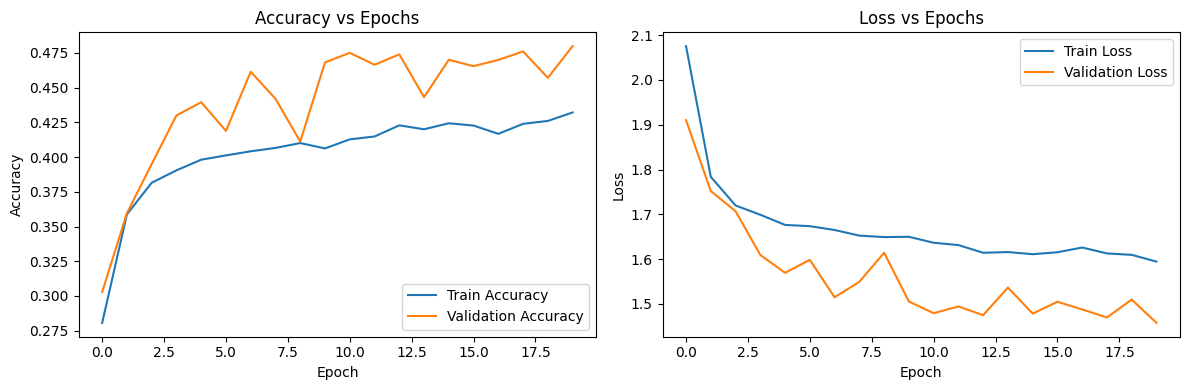

<Figure size 1000x800 with 0 Axes>

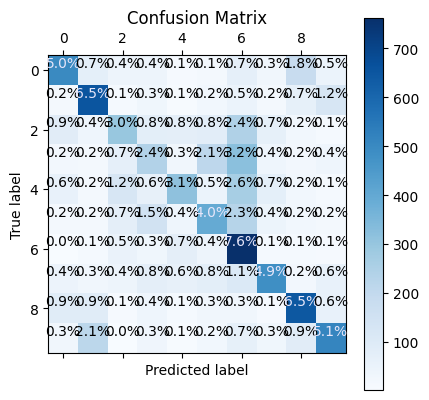

In [11]:
# Plot training history
visualize_results(history)

# Plot confusion matrix
visualize_confusion_matrix(y_true, y_pred)

# 2. Convolutional Neural Network (CNN)

In [12]:
# Membuat model CNN
def create_cnn_model():
    model = Sequential([
        # Blok Konvolusional 1
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Blok Konvolusional 2
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Blok Konvolusional 3
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')  # 10 kelas untuk CIFAR-10
    ])

    return model

# Inisialisasi model
cnn_model = create_cnn_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Kompilasi model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Melatih Model

In [14]:
# Callbacks untuk training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Melatih model
history = cnn_model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
    callbacks=callbacks
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 438s 547ms/step - accuracy: 0.3670 - loss: 2.0331 - val_accuracy: 0.4227 - val_loss: 1.7571 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 458s 586ms/step - accuracy: 0.6281 - loss: 1.0479 - val_accuracy: 0.7048 - val_loss: 0.8451 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 436s 558ms/step - accuracy: 0.7070 - loss: 0.8371 - val_accuracy: 0.5836 - val_loss: 1.3035 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 418s 527ms/step - accuracy: 0.7462 - loss: 0.7279 - val_accuracy: 0.7260 - val_loss: 0.7956 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 438s 522ms/step - accuracy: 0.7718 - loss: 0.6539 - val_accuracy: 0.7777 - val_loss: 0.6560 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 403s 516ms/step - accuracy: 0.7947 - loss: 0.5888 - val_accuracy: 0.7828 - val_loss: 0.6314 - learning_rate: 0.0010
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 409s 523ms/step - accura

# Evaluasi Model (Akurasi, Presisi, Recall, F1 Squared, AUC dan ROC)

In [15]:

def evaluate_metrics(y_true, y_pred, y_prob):
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=10)

    # Menghitung metrik evaluasi
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true_one_hot, y_prob, average='macro', multi_class='ovr')

    return precision, recall, f1, roc_auc

In [16]:
# Evaluasi model
test_loss, test_accuracy = cnn_model.evaluate(ds_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Konversi dataset untuk evaluasi metrik lengkap
y_true = []
y_pred = []
y_pred_proba = []

# Menghitung prediksi untuk semua data uji
for images, labels in ds_test:
    predictions = cnn_model.predict(images)
    y_pred_proba.extend(predictions)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Mengonversi ke numpy array
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Menghitung metrik evaluasi
precision, recall, f1, roc_auc = evaluate_metrics(y_true, y_pred, y_pred_proba)

# Output metrik evaluasi
print("\nMetrik Evaluasi CNN Model dengan TensorFlow:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.8316 - loss: 0.5055
Test accuracy: 0.8295
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

# Visualisasi

In [17]:
def visualize_results(history):
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.matshow(cm, cmap='Blues')
    plt.colorbar()
    plt.title('Confusion Matrix')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j] / cm.sum() * 100:.1f}%', ha='center', va='bottom', color='lavender' if cm[i, j] > cm.max() / 2 else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

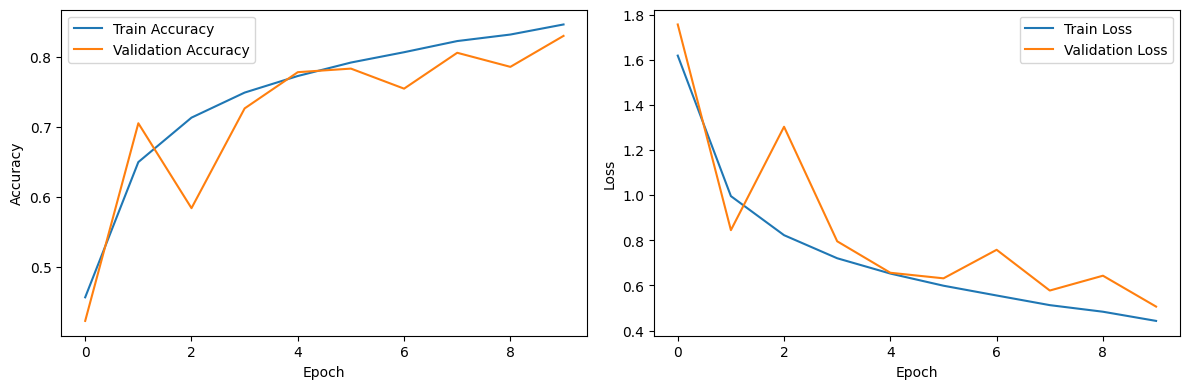

<Figure size 1000x800 with 0 Axes>

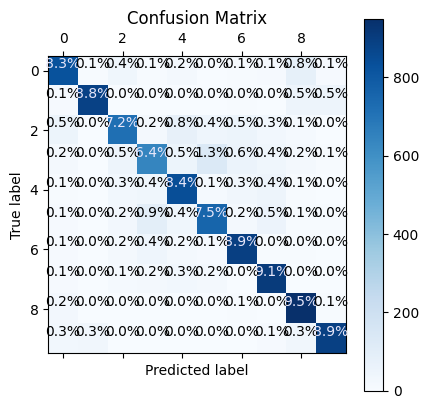

In [18]:
# Plot training history
visualize_results(history)


# Plot confusion matrix
visualize_confusion_matrix(y_true, y_pred)